In [1]:
import numpy as np
import pickle

from keras.models import Model
from keras.layers import Input, LSTM, Dense

# in kaggle
!pip install livelossplot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# get data from file_name

file_name = "xor30000"
data_path = "../input/pfa-files/" + file_name + ".txt"  # modify (kaggle/local)

with open(data_path, 'r', encoding="utf-8") as file:
    lines = file.read().split('\n')

# discard last line as it is only '\n'
lines = lines[:-1]

In [3]:
# we vectorize the data

input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

for line in lines:
    input_text, target_text, _ = line.split('\t')
    # we use '\t' and '\n' as the start and end sequence
    # characters for the target text
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

In [4]:
# constants

batch_size = 64
epochs = 100
latent_dim = 256
dropout_rate = 0.2

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
# we create chr <-> int conversion dictionaries

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [6]:
# arrays to hold the data for the model

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [7]:
# one-hot encode the data

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [8]:
# the encoder

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, dropout=dropout_rate, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]  # only keep the states

In [9]:
# the decoder

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, dropout=dropout_rate, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [10]:
# the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 112)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 77)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 377856      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  342016      input_2[0][0]                    
                                                                 lstm_1[0][1]               

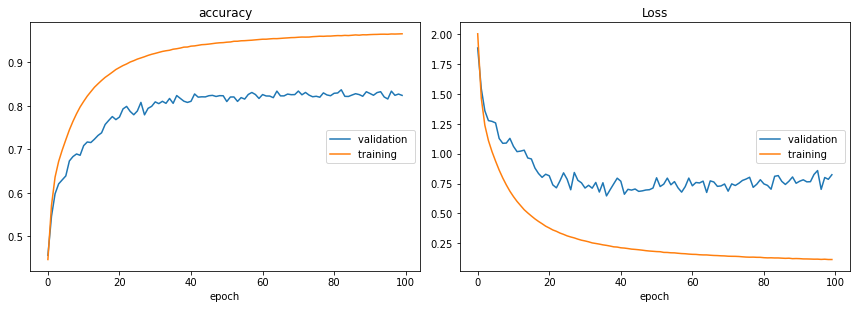

accuracy
	validation       	 (min:    0.457, max:    0.837, cur:    0.824)
	training         	 (min:    0.447, max:    0.966, cur:    0.966)
Loss
	validation       	 (min:    0.647, max:    1.887, cur:    0.825)
	training         	 (min:    0.114, max:    2.005, cur:    0.114)


In [12]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[PlotLossesKeras()],
                    verbose=1
                   )

In [13]:
model.save("xor_v3.h5")

In [22]:
info_to_Pickle = {"input_token_index": input_token_index,
                  "target_token_index": target_token_index,
                  "num_encoder_tokens": num_encoder_tokens,
                  "num_decoder_tokens": num_decoder_tokens,
                  "max_encoder_seq_length": max_encoder_seq_length,
                  "max_decoder_seq_length": max_decoder_seq_length,
                  "latent_dim": latent_dim
                 }

with open("pickledInfo.pickle", "wb") as pickle_file:
    pickle.dump(info_to_Pickle, pickle_file)